<a href="https://colab.research.google.com/github/nv-hiep/flight_delay_prediction/blob/master/step3b_naive_bayes_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 3: Gradient Boosting Model**

**NOTE: Instead of predicting the delay time in minutes, I'll predict in delay intervals:**

**0: ARR_DELAY <= 0 for no delay**

**1: 0 < ARR_DELAY <= 30 (minutes)**

**2: 30 < ARR_DELAY <= 60 (minutes)**

**3: 60 < ARR_DELAY <= 120 (minutes)**

**43: 120 < ARR_DELAY**

**Connect and authorize google drive with google colab:**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
# !ls

Mounted at /content/gdrive


# 1. Import Libraries



In [2]:
import os
import numpy   as np
import pandas  as pd
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline  

In [3]:
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, roc_curve, classification_report

from sklearn.neighbors import KNeighborsClassifier
from collections import defaultdict

from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [4]:
from hyperopt import fmin, hp, tpe, Trials, space_eval
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from functools import partial

from sklearn.svm import SVC

from sklearn import datasets
from sklearn.utils import shuffle

# 2. Data directory

In [5]:
data_dir = '/content/gdrive/My Drive/data'
%cd '/content/gdrive/My Drive/data'

current_dir = os.getcwd()
print(current_dir)
data_path = os.path.join(data_dir, 'flights', '')
print(data_path)

/content/gdrive/My Drive/data
/content/gdrive/My Drive/data
/content/gdrive/My Drive/data/flights/


# 3. Read data

In [6]:
# Read clean sub-data from csv
df_sub = pd.read_csv( os.path.join(data_path, 'cleaned_data_jan_20klines.csv') )
print('Number of columns: ', len(df_sub.columns))
df_sub.tail()

Number of columns:  15


,ARR_TIME,CRS_ARR_TIME,TAIL_NUM,DISTANCE,OP_CARRIER_FL_NUM,DEP_TIME,TAXI_OUT,DEST,ORIGIN,TAXI_IN,DAY_OF_MONTH,CARRIER_DELAY,NAS_DELAY,LATE_AIRCRAFT_DELAY,DELAYED
19995,22.42,20.83,695,1855.0,5175,16.73,17.0,180,261,5.0,8,11.0,0.0,84.0,3
19996,15.53,15.42,3050,1845.0,4738,9.48,31.0,188,261,5.0,8,0.0,0.0,0.0,1
19997,16.72,16.08,4131,651.0,2498,13.98,16.0,223,261,4.0,8,0.0,0.0,38.0,2
19998,23.43,21.17,3754,651.0,3226,20.70,14.0,223,261,4.0,8,0.0,0.0,136.0,4
19999,11.08,11.25,743,651.0,4798,8.35,17.0,223,261,4.0,8,0.0,0.0,0.0,0


In [7]:
# Checking the null values
df_sub.isnull().sum()

ARR_TIME               0
CRS_ARR_TIME           0
TAIL_NUM               0
DISTANCE               0
OP_CARRIER_FL_NUM      0
DEP_TIME               0
TAXI_OUT               0
DEST                   0
ORIGIN                 0
TAXI_IN                0
DAY_OF_MONTH           0
CARRIER_DELAY          0
NAS_DELAY              0
LATE_AIRCRAFT_DELAY    0
DELAYED                0
dtype: int64

In [8]:
df_sub.dtypes

ARR_TIME               float64
CRS_ARR_TIME           float64
TAIL_NUM                 int64
DISTANCE               float64
OP_CARRIER_FL_NUM        int64
DEP_TIME               float64
TAXI_OUT               float64
DEST                     int64
ORIGIN                   int64
TAXI_IN                float64
DAY_OF_MONTH             int64
CARRIER_DELAY          float64
NAS_DELAY              float64
LATE_AIRCRAFT_DELAY    float64
DELAYED                  int64
dtype: object

In [9]:
df_sub.columns

Index(['ARR_TIME', 'CRS_ARR_TIME', 'TAIL_NUM', 'DISTANCE', 'OP_CARRIER_FL_NUM',
       'DEP_TIME', 'TAXI_OUT', 'DEST', 'ORIGIN', 'TAXI_IN', 'DAY_OF_MONTH',
       'CARRIER_DELAY', 'NAS_DELAY', 'LATE_AIRCRAFT_DELAY', 'DELAYED'],
      dtype='object')

In [10]:
df_sub.head()

,ARR_TIME,CRS_ARR_TIME,TAIL_NUM,DISTANCE,OP_CARRIER_FL_NUM,DEP_TIME,TAXI_OUT,DEST,ORIGIN,TAXI_IN,DAY_OF_MONTH,CARRIER_DELAY,NAS_DELAY,LATE_AIRCRAFT_DELAY,DELAYED
0,10.40,10.3,1373,1126.0,2186,9.22,26.0,234,76,5.0,16,0.0,0.0,0.0,1
1,10.18,10.3,1258,1126.0,2186,9.07,31.0,234,76,4.0,17,0.0,0.0,0.0,0
2,10.47,10.3,1252,1126.0,2186,9.13,44.0,234,76,5.0,18,0.0,0.0,0.0,1
3,10.78,10.3,1477,1126.0,2186,9.08,41.0,234,76,8.0,19,0.0,29.0,0.0,1
4,10.18,10.3,1505,1126.0,2186,9.05,20.0,234,76,6.0,20,0.0,0.0,0.0,0


In [11]:
# Create data and label sets
y = df_sub['DELAYED'][:1000]
X = df_sub.drop(['DELAYED'], axis=1, inplace=False)[:1000]

In [12]:
print(X.shape)
print(y.shape)

(1000, 14)
(1000,)


In [13]:
# Training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 4. Naive Bayes model

In [14]:
# Get score of the GradientBoostingClassifier on the test data
def get_model_score(clf, X_train, X_test, y_train, y_test):
    # Train the model
    # clf = GaussianNB()
    clf.fit(X_train, y_train)

    # Predict and get score on test data
    y_pred = clf.predict(X_test)
    score  = accuracy_score(y_test, y_pred)
    print('Accuracy: ', score)

    return score

In [15]:
# fit a naive_bayes.BernoulliNB() model to the data
model = BernoulliNB()
print(); print(model)
get_model_score(model, X_train, X_test, y_train, y_test)

# fit a naive_bayes.GaussianNB() model to the data
model = GaussianNB()
print(); print(model)
get_model_score(model, X_train, X_test, y_train, y_test)

# fit a naive_bayes.MultinomialNB() model to the data
model = MultinomialNB()
print(); print(model)
get_model_score(model, X_train, X_test, y_train, y_test)

# summarize the fit of the model
# classification_report(expected_y, predicted_y)
# confusion_matrix(expected_y, predicted_y)


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
Accuracy:  0.73

GaussianNB(priors=None, var_smoothing=1e-09)
Accuracy:  0.77

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Accuracy:  0.53


0.53

**NOTE: Because GaussianNB performs the best, I'll use GaussianNB model for next steps.**

BernoulliNB is often used for binary features.

MultinomialNB is often used for discrete integer features.

## 4.1 GaussianNB model and SelectKBest for Feature Selection

In [42]:
# Model
classifier = GaussianNB()

In [17]:
# Number of features in X_train
nfeatures = len( X_train.columns )
print('Number of features in X_train: ', nfeatures)

Number of features in X_train:  14


In [18]:
# SelectKBest for classification
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif

# Select 10 features and fit
selector    = SelectKBest(f_classif, k = 10)
X_train_skb = selector.fit_transform(X_train, y_train)
X_test_skb  = selector.transform(X_test)

names  = X.columns.values[selector.get_support()]
scores = selector.scores_[selector.get_support()]

names_scores = list(zip(names, scores))
ns_df        = pd.DataFrame(data = names_scores, columns=['Feature_names', 'F_Scores'])

# Sort the dataframe
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feature_names'], ascending = [False, True])
print('Features selected: ', len(ns_df))
print(ns_df_sorted)

Features selected:  10
         Feature_names    F_Scores
9  LATE_AIRCRAFT_DELAY  175.953820
7        CARRIER_DELAY  104.718385
8            NAS_DELAY   75.252374
4             TAXI_OUT   30.338138
6         DAY_OF_MONTH   11.954327
5              TAXI_IN    5.133920
3             DEP_TIME    4.156151
2             DISTANCE    3.032514
0             ARR_TIME    2.534617
1         CRS_ARR_TIME    2.091812


In [19]:
print( 'Shape of transformed X_train: ', X_train_skb.shape )
print( 'Shape of transformed X_test: ', X_test_skb.shape )

Shape of transformed X_train:  (800, 10)
Shape of transformed X_test:  (200, 10)


In [20]:
# Get the score of Gradient Boosting Model after the SelectKBest
get_model_score(classifier, X_train_skb, X_test_skb, y_train, y_test)

Accuracy:  0.765


0.765

## 4.2 GaussianNB model and PCA for Feature Selection

In [21]:
# Number of features in X_train
nfeatures = len( X_train.columns )
print('Number of features in X_train: ', nfeatures)

Number of features in X_train:  14


In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)

print('Explained variation per principal component (PC):\n {}'.format(np.round( pca.explained_variance_ratio_, 4) ))

Explained variation per principal component (PC):
 [7.215e-01 2.649e-01 7.100e-03 5.500e-03 3.000e-04 2.000e-04 1.000e-04
 1.000e-04 1.000e-04 1.000e-04]


PC1 explains 72% and PC2 26%. Together, if we keep PC1 and PC2 only, they explain 98% of the total amount of variance in the training dataset.

In [23]:
pd.DataFrame(pca.components_, columns=X.columns, index = ['PC-' + str(x) for x in range(1, 11)])

,ARR_TIME,CRS_ARR_TIME,TAIL_NUM,DISTANCE,OP_CARRIER_FL_NUM,DEP_TIME,TAXI_OUT,DEST,ORIGIN,TAXI_IN,DAY_OF_MONTH,CARRIER_DELAY,NAS_DELAY,LATE_AIRCRAFT_DELAY
PC-1,0.000090,-0.000049,0.999239,0.037215,0.001617,-0.000005,0.001539,0.004220,0.010370,7.300183e-04,-0.000465,-0.000603,0.001177,0.001715
PC-2,-0.000406,0.000668,-0.037630,0.998261,0.000423,-0.000951,0.001400,0.034814,0.028593,6.905549e-07,-0.001160,0.000864,0.004730,-0.000673
PC-3,0.001865,0.005391,0.001178,-0.019970,0.003382,0.010959,0.005970,0.910596,-0.412048,-1.487201e-02,0.000286,0.006791,0.009815,-0.008289
PC-4,-0.009755,-0.013450,0.009648,0.040746,0.013493,-0.010644,0.016411,-0.410970,-0.910046,-3.451492e-03,0.006692,-0.005409,-0.003140,-0.015178
PC-5,0.004484,0.020985,-0.001704,0.000133,-0.029813,0.039151,0.076776,-0.002377,-0.017135,7.797558e-03,-0.113850,0.132291,0.150486,0.968376
PC-6,-0.052519,-0.023743,-0.000996,-0.005000,-0.002010,0.004026,0.394545,-0.010286,0.010564,3.160462e-02,-0.077306,0.287733,0.840789,-0.209897
PC-7,-0.010169,-0.018451,0.001111,0.000774,0.114447,-0.003635,-0.193672,-0.005650,-0.002761,-3.567262e-02,-0.113429,0.928562,-0.256981,-0.080554
PC-8,-0.331306,-0.318029,-0.001391,-0.001656,0.761242,-0.309936,-0.187463,0.010437,0.013418,-4.067497e-02,-0.212403,-0.140188,0.101084,0.038315
PC-9,-0.114970,-0.095271,-0.000613,0.000150,0.229652,-0.098125,0.353636,0.005978,0.015596,-4.506747e-02,0.867287,0.122607,-0.113211,0.089058
PC-10,0.012151,0.097855,0.001018,0.000355,-0.038931,0.104713,-0.790639,-0.005656,-0.014562,1.106660e-01,0.411031,0.013931,0.411988,0.036313


Here, **pca.components_** has shape **[n_components, n_features]**. Looking at the PC1 (First Principal Component) which is the first row: **[0.000090	-0.000049	0.999239	0.037215	0.001617	-0.000005	0.001539	0.004220	0.010370	7.300183e-04	-0.000465	-0.000603	0.001177	0.001715]** we can conclude that feature TAIL_NUM, DISTANCE are the most important.

In [24]:
print( 'Shape of transformed X_train: ', X_train_pca.shape )
print( 'Shape of transformed X_test: ', X_test_pca.shape )

Shape of transformed X_train:  (800, 10)
Shape of transformed X_test:  (200, 10)


In [25]:
# Get the score of Gradient Boosting Model after the SelectKBest
get_model_score(classifier, X_train_pca, X_test_pca, y_train, y_test)

Accuracy:  0.77


0.77

## 4.3 GaussianNB model and Recursive Feature Elimination (RFE) 

In [26]:
# Number of features in X_train
nfeatures = len( X_train.columns )
print('Number of features in X_train: ', nfeatures)

Number of features in X_train:  14


In [27]:
# RFECV using GradientBoostingClassifier as estimator
estimator = GradientBoostingClassifier(n_estimators=100, random_state=0)
selector = RFECV(estimator, step=1, cv=5)
X_train_rfe = selector.fit_transform(X_train, y_train)
X_test_rfe  = selector.transform(X_test)

print( 'Supports/features selected [1/0]: ', selector.support_ )
print( 'Ranking of the features: ', selector.ranking_ )

Supports/features selected [1/0]:  [ True False False False False  True False False False False False  True
  True  True]
Ranking of the features:  [ 1 10  3  7  9  1  2  6  8  4  5  1  1  1]


In [28]:
print('Number of selected features: ', selector.n_features_)
print()
print('Grid scores: ', selector.grid_scores_)
print()
print('Feature importances: ', selector.estimator_.feature_importances_ )

Number of selected features:  5

Grid scores:  [0.65625 0.72625 0.76    0.79875 0.8275  0.82125 0.8125  0.8075  0.79875
 0.785   0.79875 0.8025  0.805   0.80375]

Feature importances:  [0.29400883 0.12719981 0.13949715 0.26579259 0.17350163]


In [29]:
# Selected features
features = X_train.columns[selector.get_support()]
print( features )
print( len(features) )

Index(['ARR_TIME', 'DEP_TIME', 'CARRIER_DELAY', 'NAS_DELAY',
       'LATE_AIRCRAFT_DELAY'],
      dtype='object')
5


In [30]:
# Get the score of Gradient Boosting Model after the RFE
get_model_score(classifier, X_train_rfe, X_test_rfe, y_train, y_test)

Accuracy:  0.78


0.78

The accuracy of the GausianNB model with the RFECV (using GradientBoostingClassifier as estimator) improves just litle (0.78 vs 0.77)

## 4.4 Get best parameters of GausianNB model with GridSearch and Cross-validation (GridSearchCV)

**Because the score of GausianNB Classifier on the test set with the use of RFE is the best (RFE: 0.78, PCA: 0.77, SelectKBest: 0.765). I'll use RFE for the next steps.**

### Parameter space

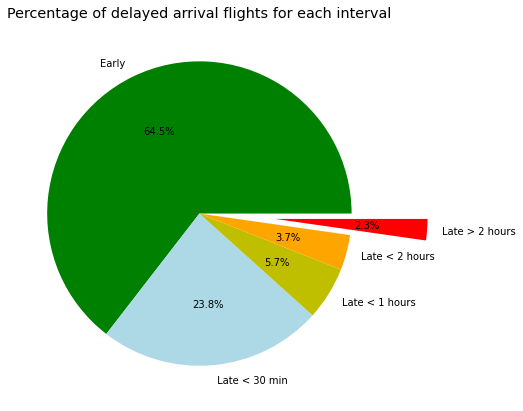

The prior of the classes [0, 1, 2, 3, 4] is [0.645, 0.238, 0.57, 0.37, 0.23] as shown in the pie chart.

In [40]:
# Parameter space
param_grid = {
    'priors': [None, [0.645, 0.238, 0.57, 0.37, 0.23]],
    'var_smoothing': np.logspace(0,-9, num=100).tolist()
    }

### GridSearchCV

In [41]:
# GridsearchCV
clf = GridSearchCV(classifier, param_grid=param_grid, cv=3, n_jobs=-1)
clf.fit(X_train_rfe, y_train)

# Get best params
print(clf.score(X_train_rfe, y_train))
print(clf.best_params_)

0.77
{'priors': None, 'var_smoothing': 0.0657933224657568}


In [43]:
# Re-train the model with best parameter from GridSearchCV
best_params = clf.best_params_
gbc = GaussianNB(priors=best_params['priors'], var_smoothing=best_params['var_smoothing'])
gbc.fit(X_train_rfe, y_train)

GaussianNB(priors=None, var_smoothing=0.0657933224657568)

In [44]:
# Predict and get score using test data
pred = gbc.predict(X_test_rfe)
# Get the score
print("Accuracy on test data: ", accuracy_score(y_test, pred))

Accuracy on test data:  0.795


**NOTE: The accuracy improved just a litle bit: from 0.78 (see above) to 0.795.**

### Prediction

In [45]:
X_new = df_sub.drop(['DELAYED'], axis=1, inplace=False)[8000:8010]
X_new

,ARR_TIME,CRS_ARR_TIME,TAIL_NUM,DISTANCE,OP_CARRIER_FL_NUM,DEP_TIME,TAXI_OUT,DEST,ORIGIN,TAXI_IN,DAY_OF_MONTH,CARRIER_DELAY,NAS_DELAY,LATE_AIRCRAFT_DELAY
8000,11.67,11.92,4239,545.0,2271,9.93,17.0,17,218,7.0,10,0.0,0.0,0.0
8001,21.60,21.93,862,502.0,2272,19.90,17.0,167,81,10.0,10,0.0,0.0,0.0
8002,8.12,8.30,4280,306.0,2273,6.82,13.0,17,119,4.0,10,0.0,0.0,0.0
8003,23.50,23.73,4294,143.0,2275,22.77,13.0,11,17,5.0,10,0.0,0.0,0.0
8004,9.45,9.63,4473,950.0,2276,6.85,13.0,167,178,14.0,10,0.0,0.0,0.0
8005,13.77,13.83,4388,534.0,2277,12.18,13.0,135,17,6.0,10,0.0,0.0,0.0
8006,16.15,16.53,4388,534.0,2277,14.45,11.0,17,135,6.0,10,0.0,0.0,0.0
8007,14.63,13.37,4073,297.0,2278,12.40,70.0,200,188,3.0,10,0.0,52.0,24.0
8008,11.93,11.30,4073,297.0,2278,9.97,61.0,188,200,4.0,10,0.0,38.0,0.0
8009,20.48,21.00,4460,746.0,2280,18.18,14.0,17,94,9.0,10,0.0,0.0,0.0


In [46]:
df_sub['DELAYED'][8000:8010]

8000    0
8001    0
8002    0
8003    0
8004    0
8005    0
8006    0
8007    3
8008    2
8009    0
Name: DELAYED, dtype: int64

In [47]:
X_new_rfe = selector.transform(X_new)

print(X_new_rfe.shape)
X_new_rfe

(10, 5)


array([[11.67,  9.93,  0.  ,  0.  ,  0.  ],
       [21.6 , 19.9 ,  0.  ,  0.  ,  0.  ],
       [ 8.12,  6.82,  0.  ,  0.  ,  0.  ],
       [23.5 , 22.77,  0.  ,  0.  ,  0.  ],
       [ 9.45,  6.85,  0.  ,  0.  ,  0.  ],
       [13.77, 12.18,  0.  ,  0.  ,  0.  ],
       [16.15, 14.45,  0.  ,  0.  ,  0.  ],
       [14.63, 12.4 ,  0.  , 52.  , 24.  ],
       [11.93,  9.97,  0.  , 38.  ,  0.  ],
       [20.48, 18.18,  0.  ,  0.  ,  0.  ]])

In [48]:
print('Prediction: ', gbc.predict(X_new_rfe).tolist())
print('True labels: ', df_sub['DELAYED'][8000:8010].tolist())

Prediction:  [0, 0, 0, 0, 0, 0, 0, 2, 2, 0]
True labels:  [0, 0, 0, 0, 0, 0, 0, 3, 2, 0]


## 4.5 Get best parameters of GaussianNB model with Hyperopt


### Parameter space

In [49]:
# Number of features in X_train
nfeatures = len( X_train.columns )
print('Number of features in X_train: ', nfeatures)

Number of features in X_train:  14


In [55]:
# Params space
hp_space_clf = {
    'clf': {
        'priors': hp.choice('priors', [None, [0.645, 0.238, 0.57, 0.37, 0.23]] ),
        'var_smoothing': hp.choice('var_smoothing', np.logspace(0,-9, num=100).tolist() )
    }
}

# Draw random sample to see if hyperspace is correctly defined
ho_sample(hp_space_clf)

{'clf': {'priors': None, 'var_smoothing': 1.873817422860387e-09}}

### Defining model

In [57]:
def f_clf(hps):
    """
    Constructs estimator
    
    Parameters:
    ----------------
    hps : sample point from search space
    
    Returns:
    ----------------
    model : sklearn.Pipeline.pipeline with hyperparameters set up as per hps
    """
    
    # Assembing pipeline if needed
    # model = Pipeline([
    #     ('clf', GradientBoostingClassifier(**hps['clf'], random_state=42))
    # ])
    
    model = GaussianNB(**hps['clf'] )
    
    return model

### Defining objective function

Define function to minimize. I'll use cross-validation score on train set.

In [122]:
def fcn_to_minimize(hps, X, y, ncv=5):
    """
    Target function for optimization
    
    Parameters:
    ----------------
    hps : sample point from search space
    X : feature matrix
    y : target array
    ncv : number of folds for cross-validation
    
    Returns:
    ----------------
    : target function value (negative mean cross-val score)
    """
    
    model = f_clf(hps)

    # cv_res = cross_val_score(model, X, y, cv=StratifiedKFold(ncv, shuffle=True, random_state=31), 
    #                          scoring='roc_auc_ovo_weighted', n_jobs=-1)
    
    # cv_res = cross_val_score(model, X, y, cv=StratifiedKFold(ncv, shuffle=True, random_state=42), scoring='roc_auc_ovr_weighted', n_jobs=-1)
    # cv_res = cross_val_score(model, X, y, cv=3, n_jobs=-1)
    cv_res = cross_val_score(model, X, y, cv=StratifiedKFold(ncv, shuffle=True, random_state=42), n_jobs=-1)
    if np.any(np.isnan(cv_res) ):
      cv_res = np.array( [0.]*ncv )
    
    acc = cv_res.mean()
    
    print(cv_res)
    print("Accuracy: %0.2f (+/- %0.2f)" % (cv_res.mean(), cv_res.std() * 2))
    return {'loss': -acc, 'status': STATUS_OK}

### Running optimization

Run optimization for 100 rounds using TPE algorithm (the Tree-structured Parzen Estimator), meaning that we use TPE to suggest next sample values based on previous function evaluations. We'll use `Trials` class objects to keep track of optimization history.

**Note**: We're binding `X` and `y` arguments of target function to `X1_train` and `y1_train` respectively, using `functools.partial`, since target function of `fmin` may accept only a search space point.

In [123]:
trials_clf = Trials()
best_clf = fmin(partial(fcn_to_minimize, X=X_train_rfe, y=y_train), 
                 hp_space_clf, algo=tpe.suggest, max_evals=100, 
                 trials=trials_clf)

[0. 0. 0. 0. 0.]
Accuracy: 0.00 (+/- 0.00)
[0.7375  0.76875 0.7125  0.7625  0.75625]
Accuracy: 0.75 (+/- 0.04)
[0.75    0.76875 0.70625 0.7625  0.75625]
Accuracy: 0.75 (+/- 0.04)
[0. 0. 0. 0. 0.]
Accuracy: 0.00 (+/- 0.00)
[0.7375  0.76875 0.7125  0.7625  0.75625]
Accuracy: 0.75 (+/- 0.04)
[0. 0. 0. 0. 0.]
Accuracy: 0.00 (+/- 0.00)
[0.74375 0.76875 0.7125  0.7625  0.75625]
Accuracy: 0.75 (+/- 0.04)
[0.7375  0.76875 0.7125  0.7625  0.75625]
Accuracy: 0.75 (+/- 0.04)
[0. 0. 0. 0. 0.]
Accuracy: 0.00 (+/- 0.00)
[0.65    0.63125 0.65    0.6375  0.69375]
Accuracy: 0.65 (+/- 0.04)
[0.7375  0.76875 0.7125  0.7625  0.75625]
Accuracy: 0.75 (+/- 0.04)
[0. 0. 0. 0. 0.]
Accuracy: 0.00 (+/- 0.00)
[0.7375  0.76875 0.70625 0.7625  0.75625]
Accuracy: 0.75 (+/- 0.05)
[0.75625 0.775   0.73125 0.7625  0.7625 ]
Accuracy: 0.76 (+/- 0.03)
[0. 0. 0. 0. 0.]
Accuracy: 0.00 (+/- 0.00)
[0.6375  0.6125  0.6125  0.63125 0.65   ]
Accuracy: 0.63 (+/- 0.03)
[0.73125 0.76875 0.70625 0.76875 0.75625]
Accuracy: 0.75 (+/- 

In [125]:
# Best parameters from Hyperopt
print(space_eval(hp_space_clf, best_clf))

print('Best parameters from Hyperopt: \n')
best_clf

# NOTE: the hp.choice gives the index of the choice, so for example: max_feature: 1 -> This means the index = 1 in the list of  choices.

{'clf': {'priors': None, 'var_smoothing': 0.0657933224657568}}
Best parameters from Hyperopt: 



{'priors': 0, 'var_smoothing': 13}

### Model performance on test set

In [126]:
# Building and fitting classifier with best parameters
clf = f_clf( space_eval(hp_space_clf, best_clf) ).fit(X_train_rfe, y_train)

# Calculating performance on test set
predictions = clf.predict(X_test_rfe)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report:")
print(classification_report(y_test, predictions))

print('Best parameters:')
print(space_eval(hp_space_clf, best_clf))

Confusion Matrix:
[[124   0   0   0   0]
 [ 32  17   1   0   0]
 [  0   4   9   3   0]
 [  0   0   1   7   0]
 [  0   0   0   0   2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.89       124
           1       0.81      0.34      0.48        50
           2       0.82      0.56      0.67        16
           3       0.70      0.88      0.78         8
           4       1.00      1.00      1.00         2

    accuracy                           0.80       200
   macro avg       0.82      0.76      0.76       200
weighted avg       0.80      0.80      0.76       200

Best parameters:
{'clf': {'priors': None, 'var_smoothing': 0.0657933224657568}}


In [127]:
# Best trial
print('Score from Best trial: ', -trials_clf.best_trial['result']['loss'] )

Score from Best trial:  0.7575000000000001


In [128]:
# Accuracy score
print('Accuracy score of the model on test set (using predict() ): ', accuracy_score(y_test, predictions) )

Accuracy score of the model on test set (using predict() ):  0.795


In [129]:
# Accuracy score using predict_proba
pred_prob_y_test = clf.predict_proba(X_test_rfe)
preds = np.argmax(pred_prob_y_test, axis=1)

print('Accuracy score on test set (using predict_proba() ): ')
accuracy_score(y_test, preds)

Accuracy score on test set (using predict_proba() ): 


0.795

Test set accuracy and cross-validation scores are consistent.

**NOTE: The accuracy score from the use of Hyperopt is equal to that of GridSearchCV (0.795 and 0.795).**